Run the following cell to import the appropriate libraries:


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# UNSW-NB16 Dataset


# Introduction

Load both the raw and preprocessed datasets. The raw dataset contains the original UNSW-NB16 dataset, while the preprocessed dataset contains the dataset after it has been preprocessed for `scikit-learn`.

In [3]:
df = pd.read_parquet("./datasets/UNSW-NB15/UNSW-NB15.parquet")
normalized_df = pd.read_parquet("./datasets/UNSW-NB15/UNSW-NB15_normalized.parquet")

Introspection of the UNSW-NB16 dataset.

In [3]:
print(df.head())

print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"Number of missing values: {df.isnull().sum().sum()}")

        srcip  sport          dstip  dsport proto state       dur  sbytes  \
0  59.166.0.0   1390  149.171.126.6      53   udp   CON  0.001055     132   
1  59.166.0.0  33661  149.171.126.9    1024   udp   CON  0.036133     528   
2  59.166.0.6   1464  149.171.126.7      53   udp   CON  0.001119     146   
3  59.166.0.5   3593  149.171.126.5      53   udp   CON  0.001209     132   
4  59.166.0.3  49664  149.171.126.0      53   udp   CON  0.001169     146   

   dbytes  sttl  ...  is_ftp_login  ct_srv_src  ct_srv_dst ct_dst_ltm  \
0     164    31  ...         False           3           7          1   
1     304    31  ...         False           2           4          2   
2     178    31  ...         False          12           8          1   
3     164    31  ...         False           6           9          1   
4     178    31  ...         False           7           9          1   

   ct_src_ ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
0            3              

If a datum has a label of 0, it is considered benign. If a datum has a label of 1, it is considered malicious. Malicious data can be further classified into 9 different attack types: Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode, and Worms.

Let's view the corresponding frequencies of each attack type in the dataset.

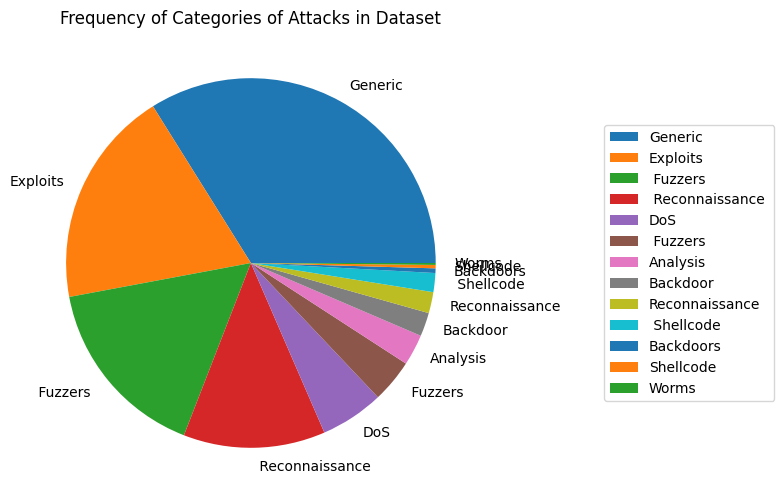

In [4]:
df[df.label == True].attack_cat.value_counts(normalize=True).plot(
    kind="pie",
    figsize=(10, 6),
    ylabel="",
    title="Frequency of Categories of Attacks in Dataset",
).legend(loc="center left", bbox_to_anchor=(1.25, 0.5))

Each datum has `stime` and `ltime` representing the record's start time and last time respectively. The data was collected during Feburary 2015.

<Axes: title={'center': 'Number of Attacks by Timestamp'}, xlabel='Timestamp', ylabel='Number of Attacks'>

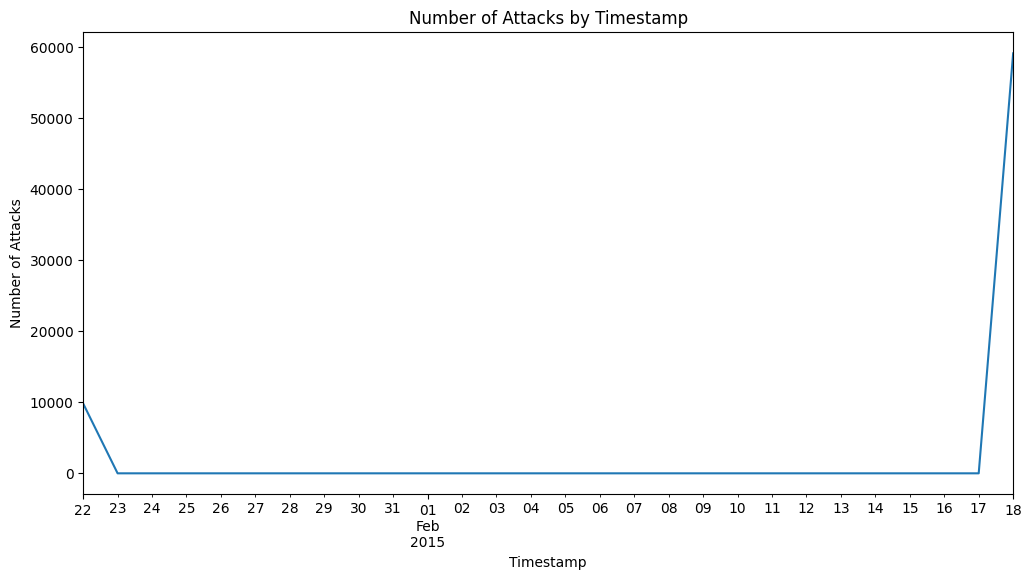

In [5]:
df[df.label == True].groupby(
    pd.Grouper(key="stime", freq="D")
).size().plot(
    kind="line",
    figsize=(12, 6),
    title="Number of Attacks by Timestamp",
    xlabel="Timestamp",
    ylabel="Number of Attacks",
)

# Identify features and labels in the dataset

Remove any columns with a constant value, as they do not provide any useful information.

In [4]:
from sklearn.feature_selection import VarianceThreshold

print(f"Number of features in dataset: {df.shape[1]}")
print(f"Number of features after encoding categorical variables: {normalized_df.shape[1]}")

# Remove the "attack_cat" and "label" columns since that is what we are trying to predict
normalized_df = normalized_df.loc[
    :, ~normalized_df.columns.str.startswith("pipeline-2__attack_cat")
].drop(columns=["pipeline-1__label"], errors="ignore")

# Remove columns with zero variance
normalized_df = normalized_df.loc[:, VarianceThreshold().fit(normalized_df).variances_ > 0]

print(f"Number of features in normalized dataset after removing constant features: {normalized_df.shape[1]}")

attacks_df = df[df.label == True]
normalized_attacks_df = normalized_df[df.label == True]

normalized_attacks_df = normalized_attacks_df.loc[:, normalized_attacks_df.var() > 0]

print(f"Number of features in normalized dataset of attacks after removing constant features: {normalized_attacks_df.shape[1]}")

Number of features in dataset: 47
Number of features after encoding categorical variables: 300
Number of features in normalized dataset after removing constant features: 286
Number of features in normalized dataset of attacks after removing constant features: 198


Now, we will identify the features that are most relevant to the dataset, or whether the record is benign or malicious (and if malicious, the type of attack). Based on the top 10 features, sttl and dttl are most important for determining its label, while stime and ltime determines its attack type.

Top 10 features: ['pipeline-1__sttl', 'pipeline-1__dttl', 'pipeline-1__ct_state_ttl', 'pipeline-1__ct_dst_src_ltm', 'pipeline-2__srcip_175.45.176.0', 'pipeline-2__srcip_175.45.176.1', 'pipeline-2__srcip_175.45.176.2', 'pipeline-2__srcip_175.45.176.3', 'pipeline-2__dstip_149.171.126.18', 'pipeline-2__state_INT']


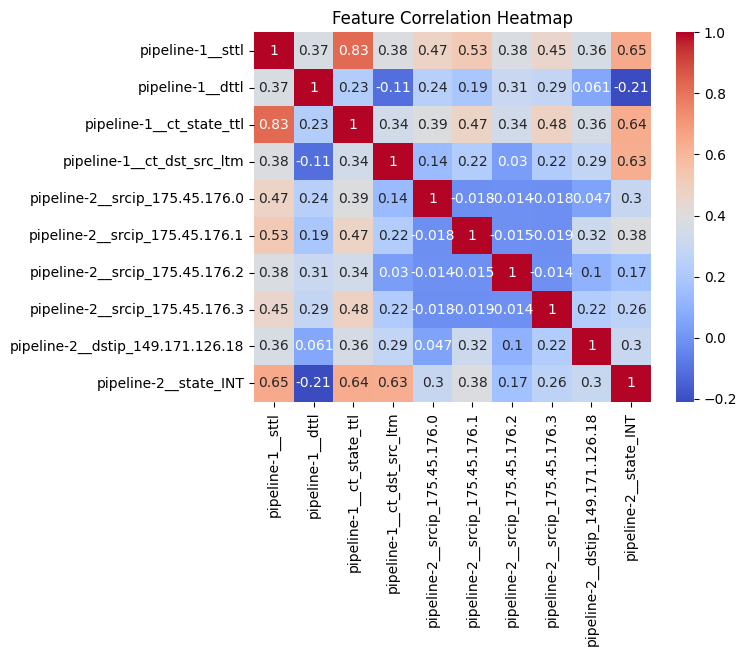

Top 10 features for attack categories: ['pipeline-1__stime', 'pipeline-1__ltime', 'pipeline-1__ct_srv_src', 'pipeline-1__ct_srv_dst', 'pipeline-1__ct_dst_ltm', 'pipeline-1__ct_src_dport_ltm', 'pipeline-1__ct_dst_sport_ltm', 'pipeline-1__ct_dst_src_ltm', 'pipeline-2__proto_udp', 'pipeline-2__state_INT']


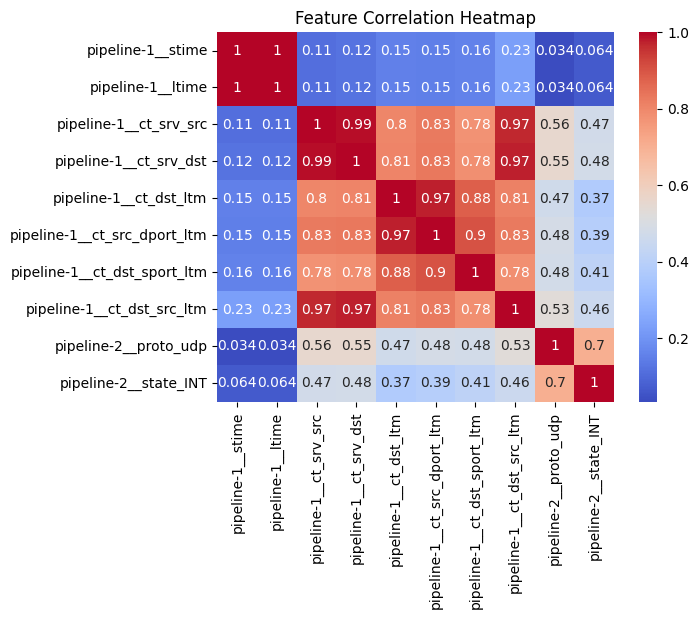

In [5]:
from sklearn.feature_selection import SelectKBest, f_classif


selector = SelectKBest(f_classif, k=10)
selector.fit(normalized_df, df.label)
selected_features = normalized_df.columns[selector.get_support()]
print(f"Top 10 features: {selected_features.to_list()}")

correlation_matrix = normalized_df[selected_features].corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

selector = SelectKBest(f_classif, k=10)
selector.fit(normalized_attacks_df, attacks_df.attack_cat)
selected_features = normalized_attacks_df.columns[selector.get_support()]

print(f"Top 10 features for attack categories: {selected_features.to_list()}")

correlation_matrix = normalized_attacks_df[selected_features].corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

If we use `SelectKBest` to find the top feature, we can see that the top feature is `sttl`. There is a very high correlation between `sttl` and whether a record is benign or malicious, having a correlation of 0.81. Using a very simple if statement `if sttl == 254`, we can detect `0.752` of malicious records with a false positive rate of `0.006`. Clearly, `sttl` correlates too much with the label, and wouldn't be useful in a real-world scenario.

Most correlated feature: pipeline-1__sttl
Correlation between 'sttl' and 'label': 0.8189706262754625


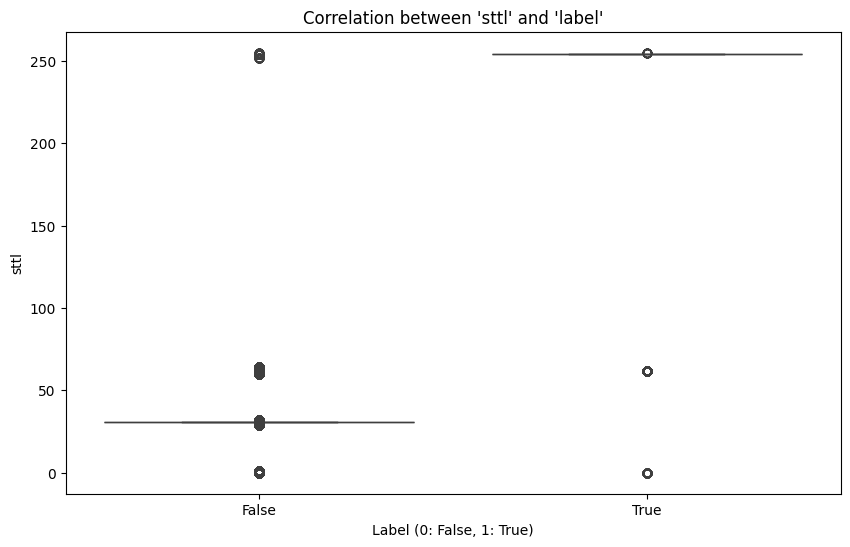

Accuracy of simple model: 0.9805980730077911
Confusion Matrix of simple model:
[[1342493   20301]
 [   7478   61493]]


In [8]:
features = normalized_df
labels = df.label

selector = SelectKBest(f_classif, k=1)
selector.fit_transform(features, labels)

print(f"Most correlated feature: {features.columns[np.argmax(selector.scores_)]}")

correlation = df.sttl.corr(df.label.astype("float"))
print(f"Correlation between 'sttl' and 'label': {correlation}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=labels, y=df.sttl)
plt.title("Correlation between 'sttl' and 'label'")
plt.xlabel("Label (0: False, 1: True)")
plt.ylabel("sttl")
plt.show()

y_pred_simple = (df.sttl == 254).astype("float")

print(f"Accuracy of simple model: {accuracy_score(labels, y_pred_simple)}")
print(f"Confusion Matrix of simple model:\n{confusion_matrix(labels, y_pred_simple)}")

However, suppose we use only the column `dload` as the feature, which is very uncorrelated with the feature (`-0.1577`). Using it to train a Gaussian Naive Bayes model, we still have a fairly high accuracy score of `0.8680`, even after controlling for overfitting.

This shows that the dataset is not very well balanced, and the features are not very well distributed. This is a common problem in cybersecurity datasets, as the data is often very skewed towards benign data. The class weights are True: 10.39, False: 0.53.

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_class_weight

features = normalized_df.loc[:, ["pipeline-1__dload"]]

print(f"Correlation between 'dload' and 'label': {features.corrwith(df["label"])}")

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(f"Accuracy of Gaussian Naive Bayes: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix of Gaussian Naive Bayes:\n{confusion_matrix(y_test, y_pred)}")
print(
    "Class Weights:",
    *zip(
        np.unique(y_train),
        compute_class_weight(
            class_weight="balanced", classes=np.unique(y_train), y=y_train
        ),
    ),
)
print(f"ROC-AUC Score: {roc_auc_score(y_test, gnb.predict_proba(X_test)[:, 1]):.4f}")

Correlation between 'dload' and 'label': pipeline-1__dload   -0.157703
dtype: float64
Accuracy of Gaussian Naive Bayes: 0.8680265266995632
Confusion Matrix of Gaussian Naive Bayes:
[[235090  37430]
 [   361  13472]]
Class Weights: (np.False_, np.float64(0.5252863041767483)) (np.True_, np.float64(10.386775000906816))
ROC-AUC Score: 0.9521


Furthermore, attempting a Gaussian Naive Bayes classifier on the dataset without any feature selection, we get a very high accuracy score of `0.9911`. Hence, we will instead consider the dataset of attacks as a multiclass classification problem, and use the `attack_cat` column as the label.

In [10]:
from sklearn.naive_bayes import GaussianNB

features = normalized_df

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(f"Accuracy of Gaussian Naive Bayes: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix of Gaussian Naive Bayes:\n{confusion_matrix(y_test, y_pred)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, gnb.predict_proba(X_test)[:, 1]):.4f}")

Accuracy of Gaussian Naive Bayes: 0.9838940049519299
Confusion Matrix of Gaussian Naive Bayes:
[[267988   4532]
 [    80  13753]]
ROC-AUC Score: 0.9911


Original shape: (68971, 210)
Shape after PCA: (68971, 10)


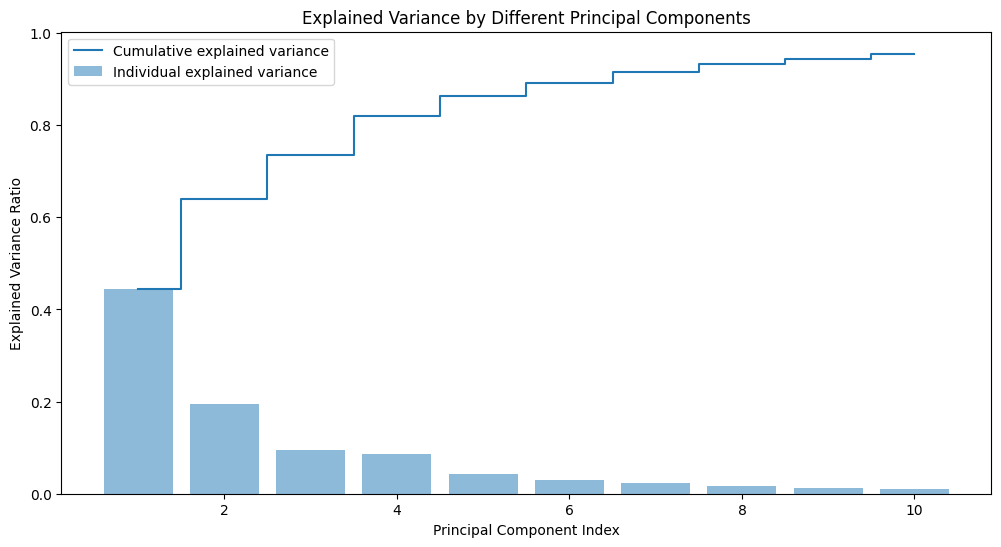

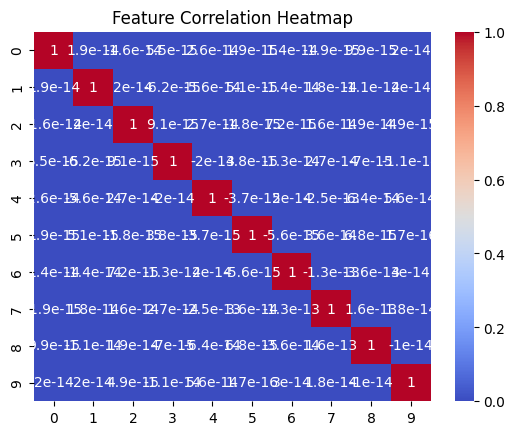

In [36]:
from sklearn.decomposition import PCA

features = normalized_attacks_df

print(f"Original shape: {features.shape}")

pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(features)

print(f"Shape after PCA: {principal_components.shape}")

plt.figure(figsize=(12, 6))
plt.bar(
  range(1, len(pca.explained_variance_ratio_) + 1),
  pca.explained_variance_ratio_,
  alpha=0.5,
  align="center",
  label="Individual explained variance",
)
plt.step(
  range(1, len(np.cumsum(pca.explained_variance_ratio_)) + 1),
  np.cumsum(pca.explained_variance_ratio_),
  where="mid",
  label="Cumulative explained variance",
)
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Different Principal Components")
plt.legend(loc="best")
plt.show()

# Predicting the attack category

Using only a basic Gaussian Naive Bayes classifier without feature selection, the accuracy is generally 0.3538. While using the Complement Naive Bayes classifier, which is a Bayesian classifier that is particularly suited for imbalanced data sets, we achieve a slightly higher accuracy of 0.4714, which is still not very high. Finally, using a much more advanced Logistic Regression classifier, we achieve an accuracy of 0.6360, which we will use as a baseline for comparison.

In [12]:
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    normalized_attacks_df, attacks_df.attack_cat, test_size=0.2, random_state=42
)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


p = Pipeline([("Normalizing", MinMaxScaler()), ("ComplementNB", ComplementNB())])
p.fit(X_train, y_train)
y_pred = p.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.3538238492207321
Accuracy: 0.47140268213120695
Accuracy: 0.6360275462123958


/Users/jeremy/Github/cogs118b/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Attempting to use a Complement Naive Bayes classifier using the principle components found by PCA, we achieve an accuracy of `0.5519`, which is an improvement over the original `0.3538`. Using the Logistic Regression classifier and the principle components found by PCA, the accuracy slightly decreases to 0.5519.

In [13]:
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    principal_components, attacks_df.attack_cat, test_size=0.2, random_state=42
)

p = Pipeline([("Normalizing", MinMaxScaler()), ("ComplementNB", ComplementNB())])
p.fit(X_train, y_train)
y_pred = p.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.5519391083725987
Accuracy: 0.5622326930047119


/Users/jeremy/Github/cogs118b/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Interestingly, adding the principal components to the original dataframe decreases accuracy on GaussianNB, but has no effect on LogisticRegression.

In [14]:
for i in range(principal_components.shape[1]):
    normalized_attacks_df[f"principal_component_{i}"] = principal_components[:, i]

X_train, X_test, y_train, y_test = train_test_split(
    normalized_attacks_df, attacks_df.attack_cat, test_size=0.2, random_state=42
)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.36310257339615803
Accuracy: 0.6275462123957956


/Users/jeremy/Github/cogs118b/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


While KMeans clustering is typically used for unsupervised learning, it may have some value in this data to assign labels to the data. Starting with 3 clusters, the graph doesn't show the most optimal clustering based on the first two principal components.

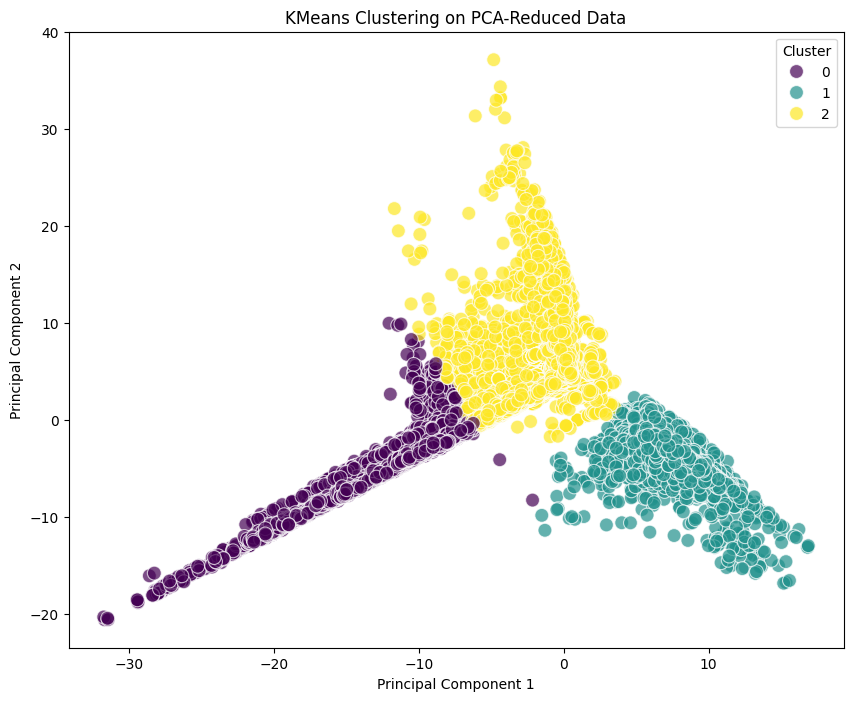

In [30]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(principal_components)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(
    principal_components,
    columns=[f"PC{i+1}" for i in range(principal_components.shape[1])],
)
pca_df["Cluster"] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="viridis", s=100, alpha=0.7
)
plt.title("KMeans Clustering on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

As an exploratory action, some value may be had in this data when assigning labels to the data based on the KMeans clusters. The chart displays the clusters based on the first two principal components, which is a little difficult to interpret.

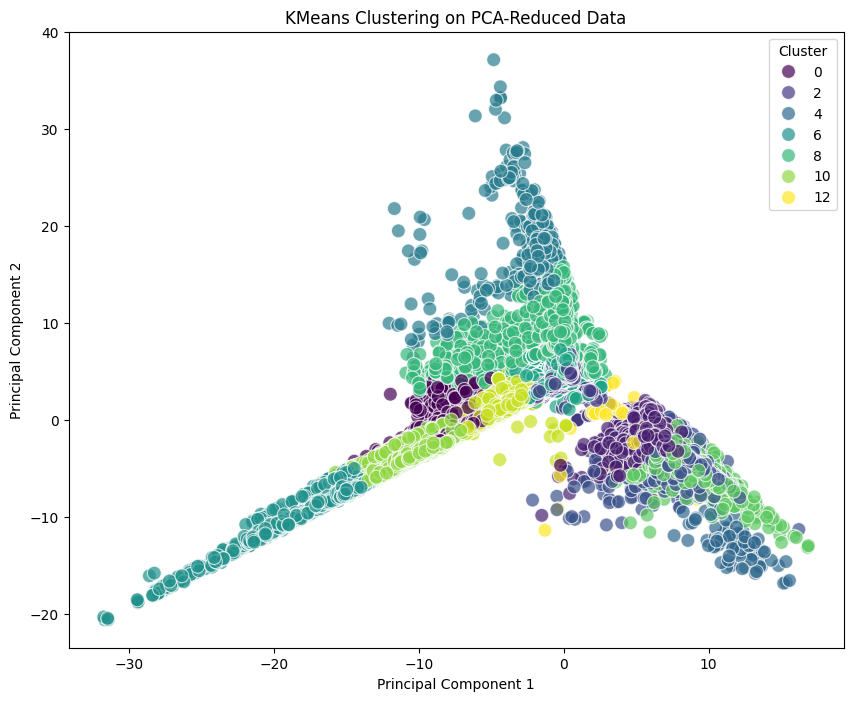

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform KMeans clustering
n_clusters = attacks_df.attack_cat.nunique()
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(principal_components)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(
    principal_components,
    columns=[f"PC{i+1}" for i in range(principal_components.shape[1])],
)
pca_df["Cluster"] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="viridis", s=100, alpha=0.7
)
plt.title("KMeans Clustering on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

The following chart shows the posterior distribution of the data, supposing a prior distribution of Beta(1,1) (uniform) for the data and calculates the posterior Beta distribution for each cluster.

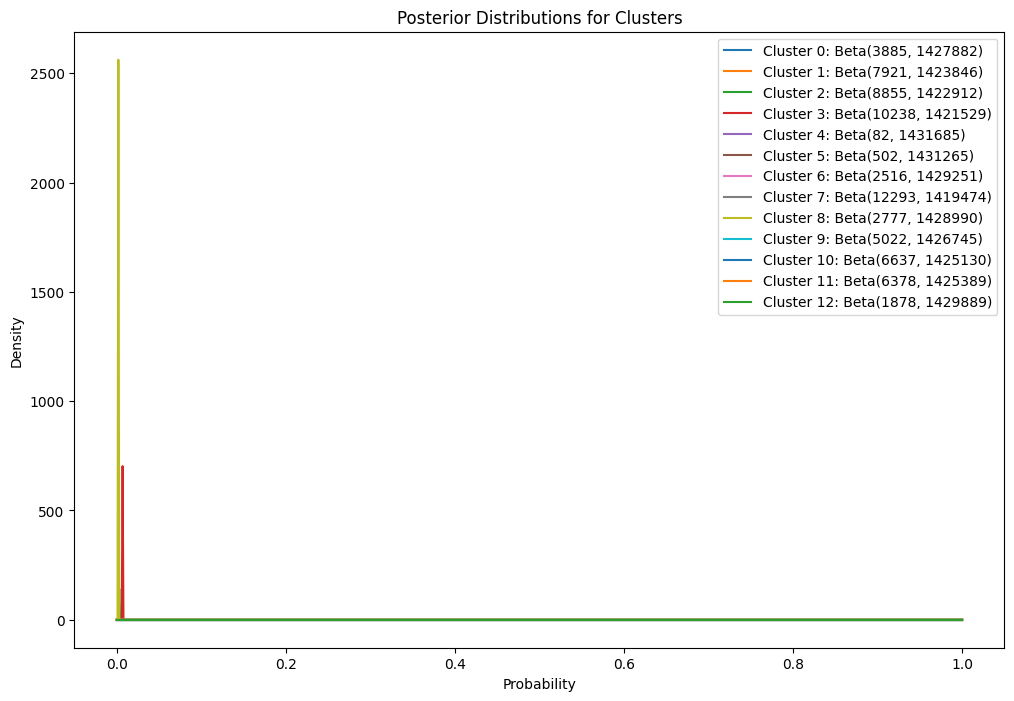

In [33]:
from scipy.stats import beta

cluster_sizes = pca_df["Cluster"].value_counts().sort_index().values
n_clusters = len(cluster_sizes)

alpha_prior, beta_prior = 1, 1

# Calculate posterior Beta distribution for each cluster
posterior_distributions = []
for i, size in enumerate(cluster_sizes):
    alpha_post = alpha_prior + size
    beta_post = beta_prior + (len(df) - size)
    posterior_distributions.append((alpha_post, beta_post))

x = np.linspace(0, 1, 1000)
plt.figure(figsize=(12, 8))

for i, (alpha_post, beta_post) in enumerate(posterior_distributions):
    y = beta.pdf(x, alpha_post, beta_post)
    plt.plot(x, y, label=f"Cluster {i}: Beta({alpha_post}, {beta_post})")

plt.title("Posterior Distributions for Clusters")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

Using only the principal components found by the PCA and the KMeans clusters, after normalizing the data to vectors of length 1, we achieve an accuracy of `0.5708` with the Gaussian Naive Bayes classifier, or an improvement over the original `0.3538`.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

X_train, X_test, y_train, y_test = train_test_split(
    pca_df, attacks_df["attack_cat"], test_size=0.3, random_state=42
)

p = Pipeline([("Normalizing", Normalizer()), ("GaussianNB", GaussianNB())])
p.fit(X_train, y_train)
y_pred = p.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.5634544751594819
